### FOR 1001 EPOCHS

In [87]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

data_dir = 'V:\\Dataset\\ACV\\mvtec_anomaly_detection'

# Dataset loading
class MyDataset(Dataset):
    def __init__(self, base_dir, data_type, transform=None):
        self.base_dir = base_dir
        self.data_type = data_type
        self.transform = transform
        self.image_files = []
        self.targets = []
        self.normal_count = 0
        self.anomaly_count = 0

        for category in os.listdir(base_dir):
            category_path = os.path.join(base_dir, category)
            if os.path.isdir(category_path):
                type_path = os.path.join(category_path, data_type)
                if os.path.isdir(type_path):
                    for defect_class in os.listdir(type_path):
                        defect_class_path = os.path.join(type_path, defect_class)
                        if os.path.isdir(defect_class_path):
                            for img_file in os.listdir(defect_class_path):
                                img_file_path = os.path.join(defect_class_path, img_file)
                                if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
                                    self.image_files.append(img_file_path)
                                    if data_type == 'train' or defect_class.lower() == 'good':
                                        self.targets.append(0)  # Normal images
                                        self.normal_count += 1
                                    else:
                                        self.targets.append(1)  # Anomalous images
                                        self.anomaly_count += 1

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = self.image_files[index]
        img = Image.open(img_path).convert('RGB')
        label = self.targets[index]
        if self.transform:
            img = self.transform(img)
        return img, label

img_transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

# Loading datasets
train_data = MyDataset(data_dir, 'train', transform=img_transform)
test_data = MyDataset(data_dir, 'test', transform=img_transform)

train_loader = DataLoader(train_data, shuffle=True, batch_size=64, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=64, drop_last=True)

print(f"Training images: {len(train_data)}")
print(f"  Normal in training set: {train_data.normal_count}")
print(f"Testing images: {len(test_data)}")
print(f"  Normal in test set: {test_data.normal_count}")
print(f"  Anomalous in test set: {test_data.anomaly_count}")

Training images: 3629
  Normal in training set: 3629
Testing images: 1725
  Normal in test set: 467
  Anomalous in test set: 1258


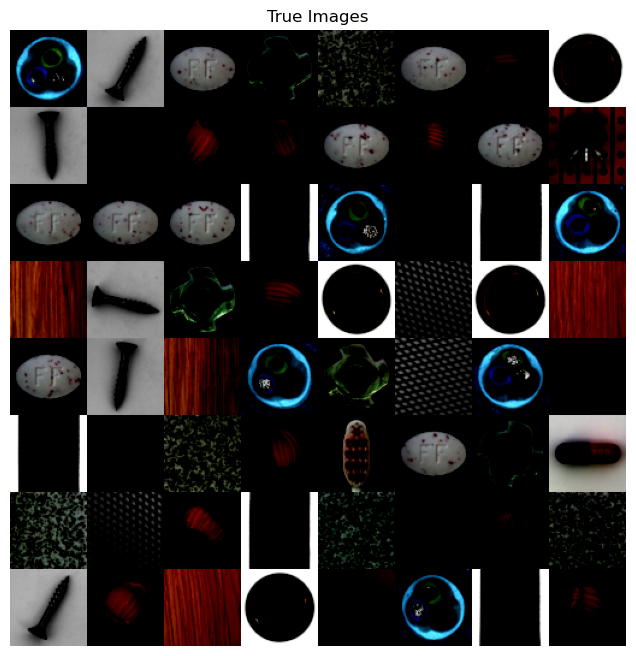

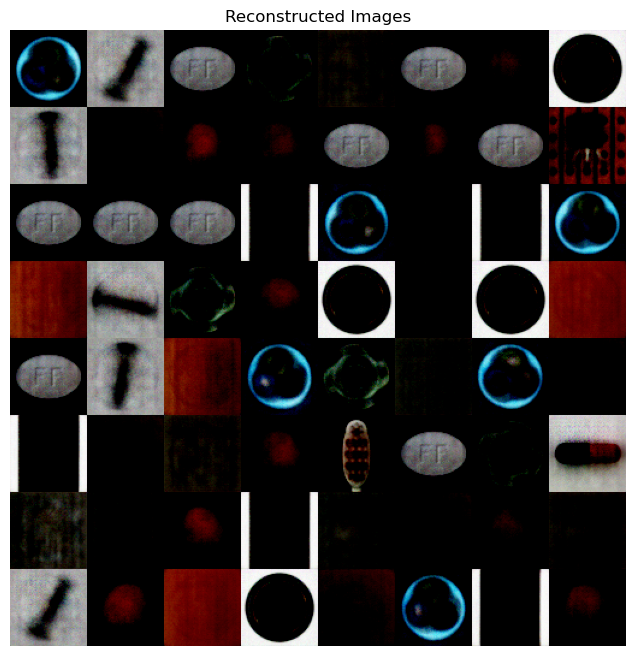

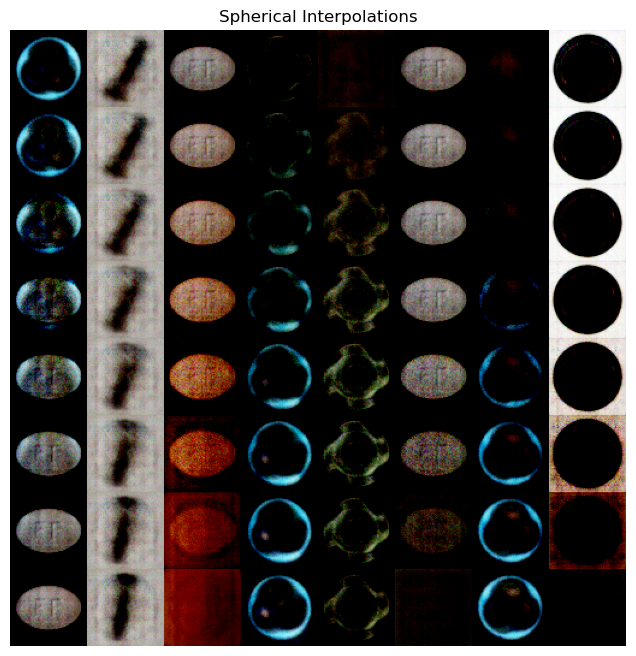

100%|██████████| 1001/1001 [34:08<00:00,  2.05s/it]


In [88]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def cycle(loader):
    while True:
        for data in loader:
            yield data

train_iter = iter(cycle(train_loader))

# Parameters Initialization
latent_size = 100  
gen_filter_size = 124  
learning_rate = 1e-4
training_steps = 1001 
batch_sz = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {'GPU' if torch.cuda.is_available() else 'CPU'}.")

class GenModel(nn.Module):
    def __init__(self):
        super(GenModel, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(latent_size, gen_filter_size * 8, 4, 1, 0, bias=True),
            nn.BatchNorm2d(gen_filter_size * 8),
            nn.ELU(),
            nn.ConvTranspose2d(gen_filter_size * 8, gen_filter_size * 4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(gen_filter_size * 4),
            nn.ELU(),
            nn.ConvTranspose2d(gen_filter_size * 4, gen_filter_size * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(gen_filter_size * 2),
            nn.ELU(),
            nn.ConvTranspose2d(gen_filter_size * 2, gen_filter_size, 4, 2, 1, bias=True),
            nn.BatchNorm2d(gen_filter_size),
            nn.ELU(),
            nn.ConvTranspose2d(gen_filter_size, 3, 4, 2, 1, bias=True),
            nn.Tanh()
        )

    def forward(self, x):
        return self.network(x)

# Initializing model and optimizer
gen_model = GenModel().to(device)
gen_optimizer = optim.Adam(gen_model.parameters(), lr=learning_rate)
print(f'> Model parameters: {sum(p.numel() for p in gen_model.parameters() if p.requires_grad)}')

def slerp(interpol, a, b):
    omega = torch.acos((a / torch.norm(a, dim=1, keepdim=True) * b / torch.norm(b, dim=1, keepdim=True)).sum(1)).unsqueeze(1)
    result = (torch.sin((1.0 - interpol) * omega) / torch.sin(omega)) * a + (torch.sin(interpol * omega) / torch.sin(omega)) * b
    return result

def slerp_gen_batch(gen, z):
    lz = z.data.clone().squeeze(-1).squeeze(-1)
    col_size = int(np.sqrt(z.size(0)))
    src_z = lz.data[:col_size].repeat(col_size, 1)
    z1, z2 = lz.data.split(lz.shape[0] // 2)
    tgt_z = torch.cat([z2, z1])
    tgt_z = tgt_z[:col_size].repeat(col_size, 1)
    t = torch.linspace(0, 1, col_size).unsqueeze(1).repeat(1, col_size).contiguous().view(batch_sz, 1).contiguous().to(device)
    z_slerp = slerp(t, src_z, tgt_z)
    g_slerp = gen(z_slerp.unsqueeze(-1).unsqueeze(-1))
    return g_slerp

# Training loop
train_losses = []
for step in tqdm(range(training_steps)):
    x, _ = next(train_iter)
    x = x.to(device)

    # Calculation of inner loss gradients with respect to zeros
    z = torch.zeros(batch_sz, latent_size, 1, 1, device=device, requires_grad=True)
    g = gen_model(z)
    inner_loss = ((g - x) ** 2).sum(1).mean()
    grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]
    z = (-grad)

    # Optimizing the data fitting loss with new latent points
    g = gen_model(z)
    outer_loss = ((g - x) ** 2).sum(1).mean()
    gen_optimizer.zero_grad()
    outer_loss.backward()
    gen_optimizer.step()

    train_losses.append(outer_loss.item())

    if step % 100 == 0:
        print(f"Step: {step}   Loss: {outer_loss.item():.3f}")

        reconstructions = torchvision.utils.make_grid(torch.clamp(g, 0, 1).detach(), padding=0, nrow=8)
        slerp_interpolations = torchvision.utils.make_grid(torch.clamp(slerp_gen_batch(gen_model, z.data).detach(), 0, 1), padding=0, nrow=8)
        true_images = torchvision.utils.make_grid(torch.clamp(x, 0, 1).detach(), padding=0, nrow=8)

        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        plt.title('True Images')
        plt.imshow(np.transpose(true_images.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')

        plt.figure(figsize=(8, 8))
        plt.title('Reconstructed Images')
        plt.imshow(np.transpose(reconstructions.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')

        plt.figure(figsize=(8, 8))
        plt.title('Spherical Interpolations')
        plt.imshow(np.transpose(slerp_interpolations.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')

        plt.show()

In [89]:
# Dynamic threshold calculation
def dynamic_threshold(loss_vals):
    mean_loss = np.mean(loss_vals)
    std_loss = np.std(loss_vals)
    return mean_loss + 2 * std_loss  

initial_threshold = dynamic_threshold(train_losses)
print(f"Initial anomaly detection threshold: {initial_threshold}")

# Computation of reconstruction errors
def reconstruction_errors(gen_model, data_loader):
    gen_model.eval()
    errors = []
    true_labels = []
    with torch.no_grad():
        for imgs, labels in tqdm(data_loader, desc="Evaluating"):
            imgs = imgs.to(device)
            z = torch.zeros(imgs.size(0), latent_size, 1, 1, device=device)
            gen_imgs = gen_model(z)
            loss = torch.mean((gen_imgs - imgs) ** 2, dim=[1, 2, 3])
            errors.extend(loss.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return np.array(errors), np.array(true_labels)

recon_errors, true_lbls = reconstruction_errors(gen_model, test_loader)

assert recon_errors.shape == true_lbls.shape, "Shape mismatch between errors and true labels."

# Anomaly detection using the threshold
anomalies_detected = recon_errors > initial_threshold
print(f"Detected anomalies: {np.sum(anomalies_detected)}")

true_labels_list = []
pred_labels_list = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Anomaly Detection"):
        imgs = imgs.to(device)
        z = torch.zeros(imgs.size(0), latent_size, 1, 1, device=device)
        gen_imgs = gen_model(z)
        recon_error = torch.mean((gen_imgs - imgs) ** 2, dim=[1, 2, 3]).cpu().numpy()
        true_labels_list.extend(labels.cpu().numpy())
        pred_labels_list.extend([1 if e > initial_threshold else 0 for e in recon_error])

print(f"Anomalies detected in the test set: {np.sum(anomalies_detected)}")

Initial anomaly detection threshold: 0.36214418688301125


Evaluating: 100%|██████████| 26/26 [00:41<00:00,  1.58s/it]


Detected anomalies: 605


Anomaly Detection: 100%|██████████| 26/26 [00:40<00:00,  1.56s/it]

Anomalies detected in the test set: 605


c:\ProgramData\anaconda3\envs\Seminar_project\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


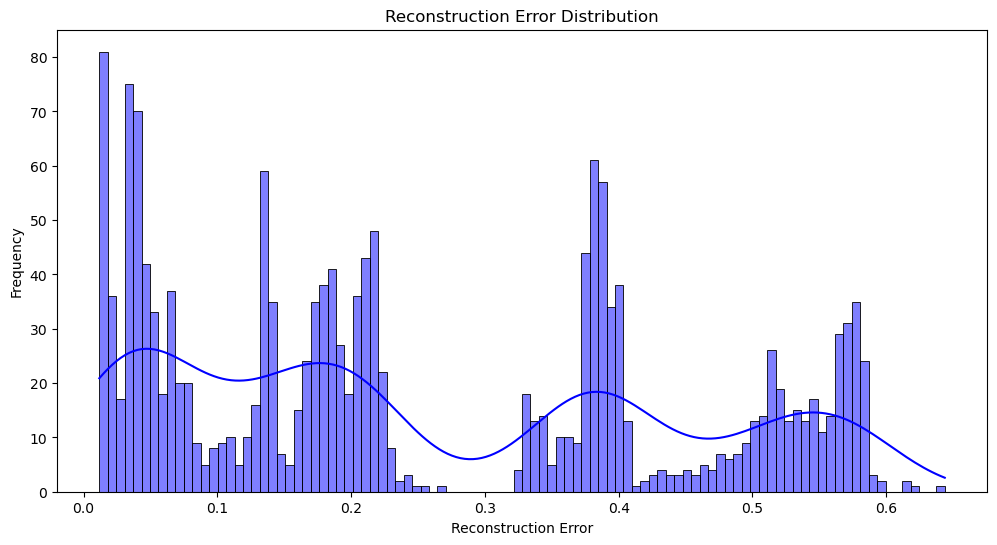

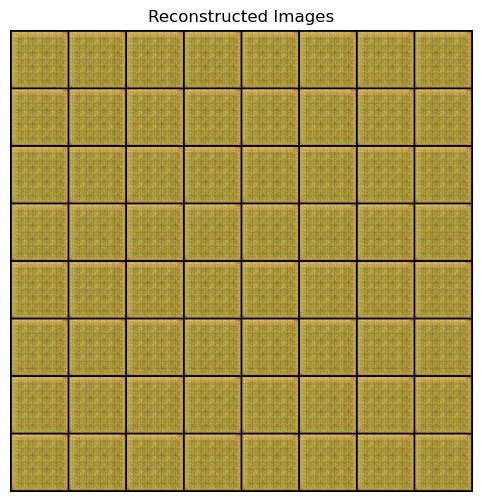

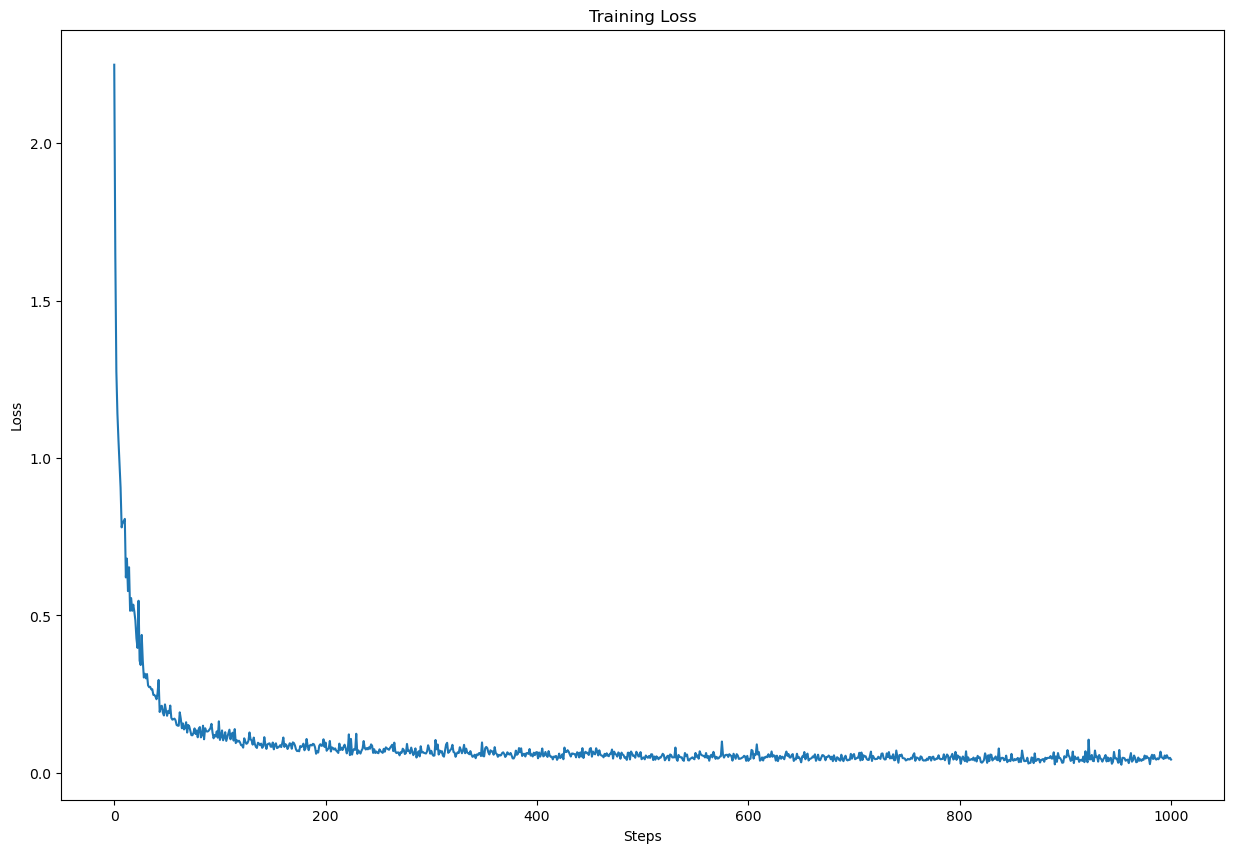

c:\ProgramData\anaconda3\envs\Seminar_project\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


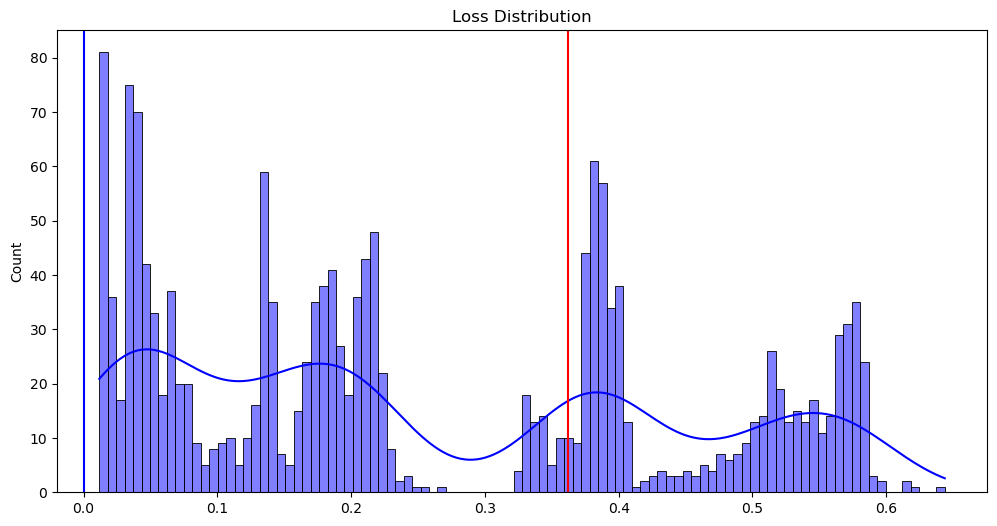

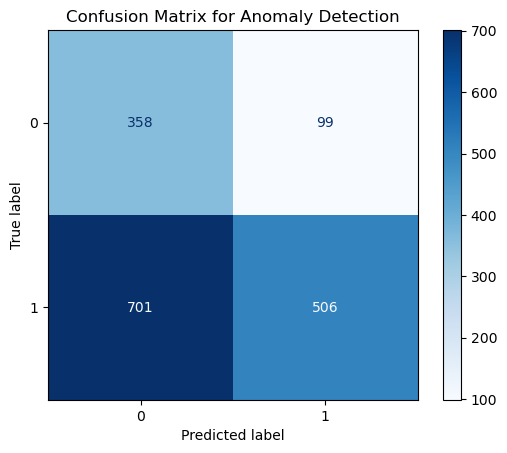

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

# Reconstruction error distribution
plt.figure(figsize=(12, 6))
plt.title('Reconstruction Error Distribution')
sns.histplot(recon_errors, bins=100, kde=True, color='blue')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Reconstructed images
z = torch.zeros(imgs.size(0), latent_size, 1, 1, device=device)
with torch.no_grad():
    gen_imgs = gen_model(z)

plt.figure(figsize=(12, 6))
plt.title('Reconstructed Images')
plt.imshow(np.transpose(torchvision.utils.make_grid(gen_imgs.cpu().detach(), padding=2, normalize=True), (1, 2, 0)))
plt.axis('off')
plt.show()

# Training loss
plt.figure(figsize=(15, 10))
plt.title('Training Loss')
plt.plot(train_losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

# Loss distribution
plt.figure(figsize=(12, 6))
plt.title('Loss Distribution')
sns.histplot(recon_errors, bins=100, kde=True, color='blue')
plt.axvline(initial_threshold, color='r')
plt.axvline(0.0, color='b')
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(true_labels_list, pred_labels_list)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Anomaly Detection')
plt.show()

###  FOR 3001 EPOCHS



In [82]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T


data_dir = 'V:\\Dataset\\ACV\\mvtec_anomaly_detection'

# Dataset  loading 
class MyDataset(Dataset):
    def __init__(self, base_dir, data_type, transform=None):
        self.base_dir = base_dir
        self.data_type = data_type
        self.transform = transform
        self.image_files = []
        self.targets = []
        self.normal_count = 0
        self.anomaly_count = 0

        for category in os.listdir(base_dir):
            category_path = os.path.join(base_dir, category)
            if os.path.isdir(category_path):
                type_path = os.path.join(category_path, data_type)
                if os.path.isdir(type_path):
                    for defect_class in os.listdir(type_path):
                        defect_class_path = os.path.join(type_path, defect_class)
                        if os.path.isdir(defect_class_path):
                            for img_file in os.listdir(defect_class_path):
                                img_file_path = os.path.join(defect_class_path, img_file)
                                if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
                                    self.image_files.append(img_file_path)
                                    if data_type == 'train' or defect_class.lower() == 'good':
                                        self.targets.append(0)  # Normal images
                                        self.normal_count += 1
                                    else:
                                        self.targets.append(1)  # Anomalous images
                                        self.anomaly_count += 1

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = self.image_files[index]
        img = Image.open(img_path).convert('RGB')
        label = self.targets[index]
        if self.transform:
            img = self.transform(img)
        return img, label

img_transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

# Loading datasets
train_data = MyDataset(data_dir, 'train', transform=img_transform)
test_data = MyDataset(data_dir, 'test', transform=img_transform)

train_loader = DataLoader(train_data, shuffle=True, batch_size=64, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=64, drop_last=True)

print(f"Training images: {len(train_data)}")
print(f"  Normal in training set: {train_data.normal_count}")
print(f"Testing images: {len(test_data)}")
print(f"  Normal in test set: {test_data.normal_count}")
print(f"  Anomalous in test set: {test_data.anomaly_count}")

Training images: 3629
  Normal in training set: 3629
Testing images: 1725
  Normal in test set: 467
  Anomalous in test set: 1258


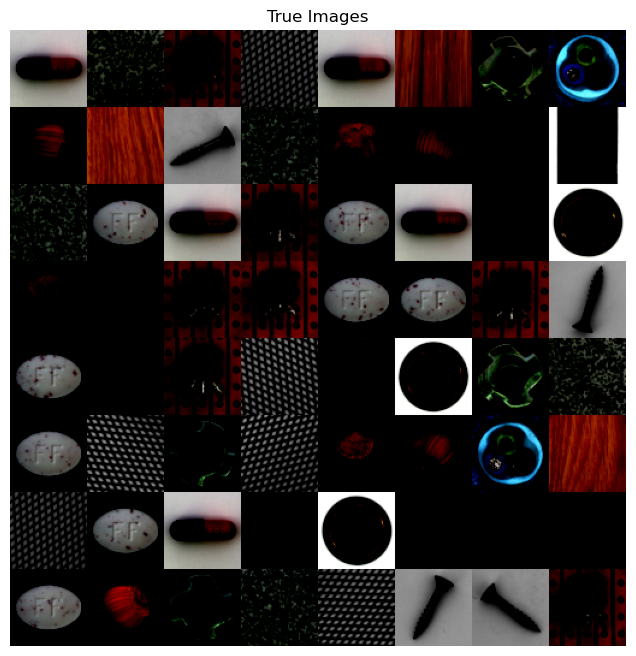

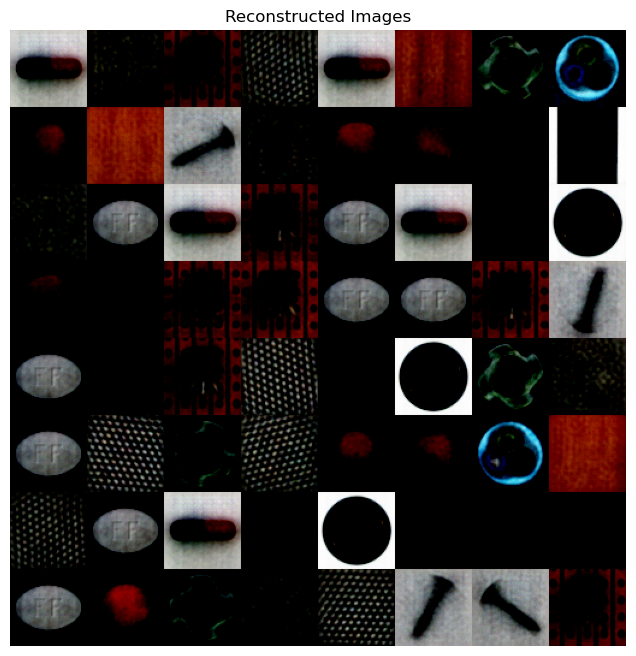

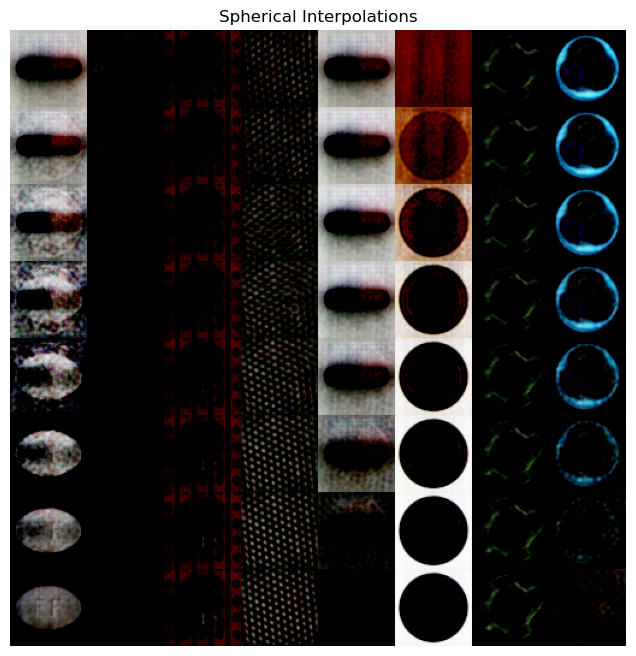

100%|██████████| 3001/3001 [1:54:06<00:00,  2.28s/it]


In [83]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def cycle(loader):
    while True:
        for data in loader:
            yield data

train_iter = iter(cycle(train_loader))

# Parameters Initialization
latent_size = 100  
gen_filter_size = 124  
learning_rate = 1e-4
training_steps = 3001  
batch_sz = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {'GPU' if torch.cuda.is_available() else 'CPU'}.")

class GenModel(nn.Module):
    def __init__(self):
        super(GenModel, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(latent_size, gen_filter_size * 8, 4, 1, 0, bias=True),
            nn.BatchNorm2d(gen_filter_size * 8),
            nn.ELU(),
            nn.ConvTranspose2d(gen_filter_size * 8, gen_filter_size * 4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(gen_filter_size * 4),
            nn.ELU(),
            nn.ConvTranspose2d(gen_filter_size * 4, gen_filter_size * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(gen_filter_size * 2),
            nn.ELU(),
            nn.ConvTranspose2d(gen_filter_size * 2, gen_filter_size, 4, 2, 1, bias=True),
            nn.BatchNorm2d(gen_filter_size),
            nn.ELU(),
            nn.ConvTranspose2d(gen_filter_size, 3, 4, 2, 1, bias=True),
            nn.Tanh()
        )

    def forward(self, x):
        return self.network(x)

# Initializing model and optimizer
gen_model = GenModel().to(device)
gen_optimizer = optim.Adam(gen_model.parameters(), lr=learning_rate)
print(f'> Model parameters: {sum(p.numel() for p in gen_model.parameters() if p.requires_grad)}')

def slerp(interpol, a, b):
    omega = torch.acos((a / torch.norm(a, dim=1, keepdim=True) * b / torch.norm(b, dim=1, keepdim=True)).sum(1)).unsqueeze(1)
    result = (torch.sin((1.0 - interpol) * omega) / torch.sin(omega)) * a + (torch.sin(interpol * omega) / torch.sin(omega)) * b
    return result

def slerp_gen_batch(gen, z):
    lz = z.data.clone().squeeze(-1).squeeze(-1)
    col_size = int(np.sqrt(z.size(0)))
    src_z = lz.data[:col_size].repeat(col_size, 1)
    z1, z2 = lz.data.split(lz.shape[0] // 2)
    tgt_z = torch.cat([z2, z1])
    tgt_z = tgt_z[:col_size].repeat(col_size, 1)
    t = torch.linspace(0, 1, col_size).unsqueeze(1).repeat(1, col_size).contiguous().view(batch_sz, 1).contiguous().to(device)
    z_slerp = slerp(t, src_z, tgt_z)
    g_slerp = gen(z_slerp.unsqueeze(-1).unsqueeze(-1))
    return g_slerp

# Training loop
train_losses = []
for step in tqdm(range(training_steps)):
    x, _ = next(train_iter)
    x = x.to(device)

    # Calculation of inner loss gradients with respect to zeros
    z = torch.zeros(batch_sz, latent_size, 1, 1, device=device, requires_grad=True)
    g = gen_model(z)
    inner_loss = ((g - x) ** 2).sum(1).mean()
    grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]
    z = (-grad)

    # Optimization the data fitting loss with new latent points
    g = gen_model(z)
    outer_loss = ((g - x) ** 2).sum(1).mean()
    gen_optimizer.zero_grad()
    outer_loss.backward()
    gen_optimizer.step()

    train_losses.append(outer_loss.item())

    if step % 100 == 0:
        print(f"Step: {step}   Loss: {outer_loss.item():.3f}")

        reconstructions = torchvision.utils.make_grid(torch.clamp(g, 0, 1).detach(), padding=0, nrow=8)
        slerp_interpolations = torchvision.utils.make_grid(torch.clamp(slerp_gen_batch(gen_model, z.data).detach(), 0, 1), padding=0, nrow=8)
        true_images = torchvision.utils.make_grid(torch.clamp(x, 0, 1).detach(), padding=0, nrow=8)

        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        plt.title('True Images')
        plt.imshow(np.transpose(true_images.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')

        plt.figure(figsize=(8, 8))
        plt.title('Reconstructed Images')
        plt.imshow(np.transpose(reconstructions.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')

        plt.figure(figsize=(8, 8))
        plt.title('Spherical Interpolations')
        plt.imshow(np.transpose(slerp_interpolations.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')

        plt.show()

In [84]:
# Dynamic threshold calculation
def dynamic_threshold(loss_vals):
    mean_loss = np.mean(loss_vals)
    std_loss = np.std(loss_vals)
    return mean_loss + 2 * std_loss  

# Initialization of anomaly detection threshold
initial_threshold = dynamic_threshold(train_losses)
print(f"Initial anomaly detection threshold: {initial_threshold}")

# Computation of reconstruction errors
def reconstruction_errors(gen_model, data_loader):
    gen_model.eval()
    errors = []
    true_labels = []
    with torch.no_grad():
        for imgs, labels in tqdm(data_loader, desc="Evaluating"):
            imgs = imgs.to(device)
            z = torch.zeros(imgs.size(0), latent_size, 1, 1, device=device)
            gen_imgs = gen_model(z)
            loss = torch.mean((gen_imgs - imgs) ** 2, dim=[1, 2, 3])
            errors.extend(loss.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return np.array(errors), np.array(true_labels)

recon_errors, true_lbls = reconstruction_errors(gen_model, test_loader)

assert recon_errors.shape == true_lbls.shape, "Shape mismatch between errors and true labels."

# Anomaly detection using the threshold
anomalies_detected = recon_errors > initial_threshold
print(f"Detected anomalies: {np.sum(anomalies_detected)}")

# Anomaly detection on test data
true_labels_list = []
pred_labels_list = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Anomaly Detection"):
        imgs = imgs.to(device)
        z = torch.zeros(imgs.size(0), latent_size, 1, 1, device=device)
        gen_imgs = gen_model(z)
        recon_error = torch.mean((gen_imgs - imgs) ** 2, dim=[1, 2, 3]).cpu().numpy()
        true_labels_list.extend(labels.cpu().numpy())
        pred_labels_list.extend([1 if e > initial_threshold else 0 for e in recon_error])

print(f"Anomalies detected in the test set: {np.sum(anomalies_detected)}")

Initial anomaly detection threshold: 0.2213952564167225


Evaluating: 100%|██████████| 26/26 [00:41<00:00,  1.58s/it]


Detected anomalies: 680


Anomaly Detection: 100%|██████████| 26/26 [00:40<00:00,  1.57s/it]

Anomalies detected in the test set: 680


c:\ProgramData\anaconda3\envs\Seminar_project\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


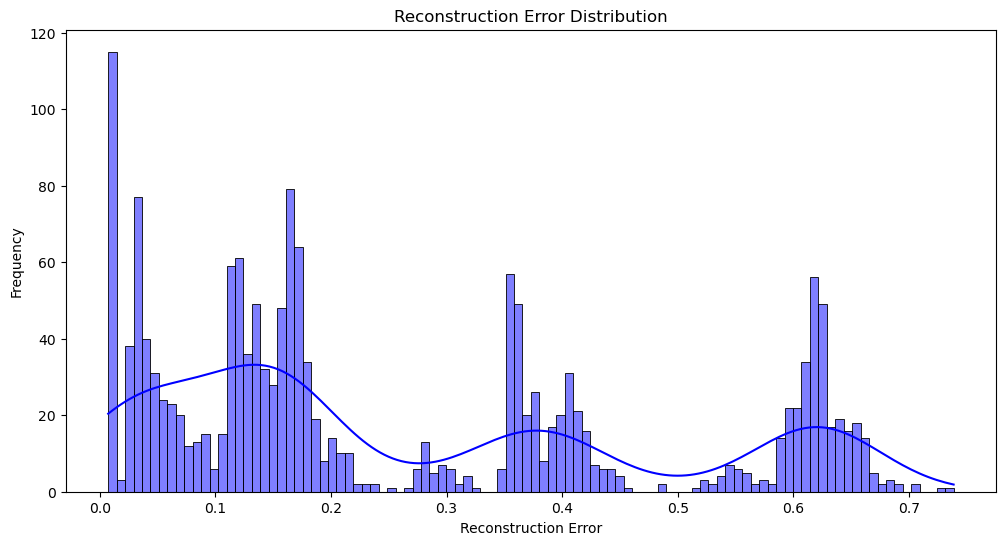

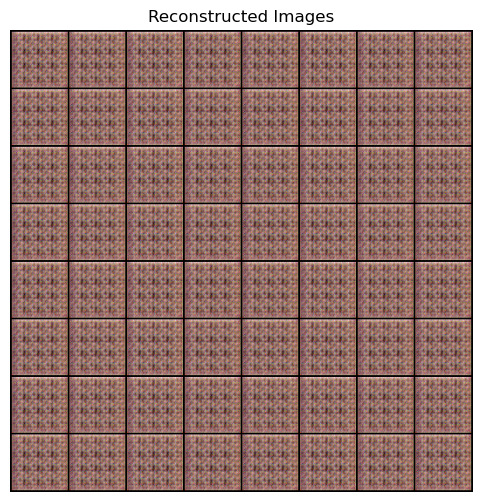

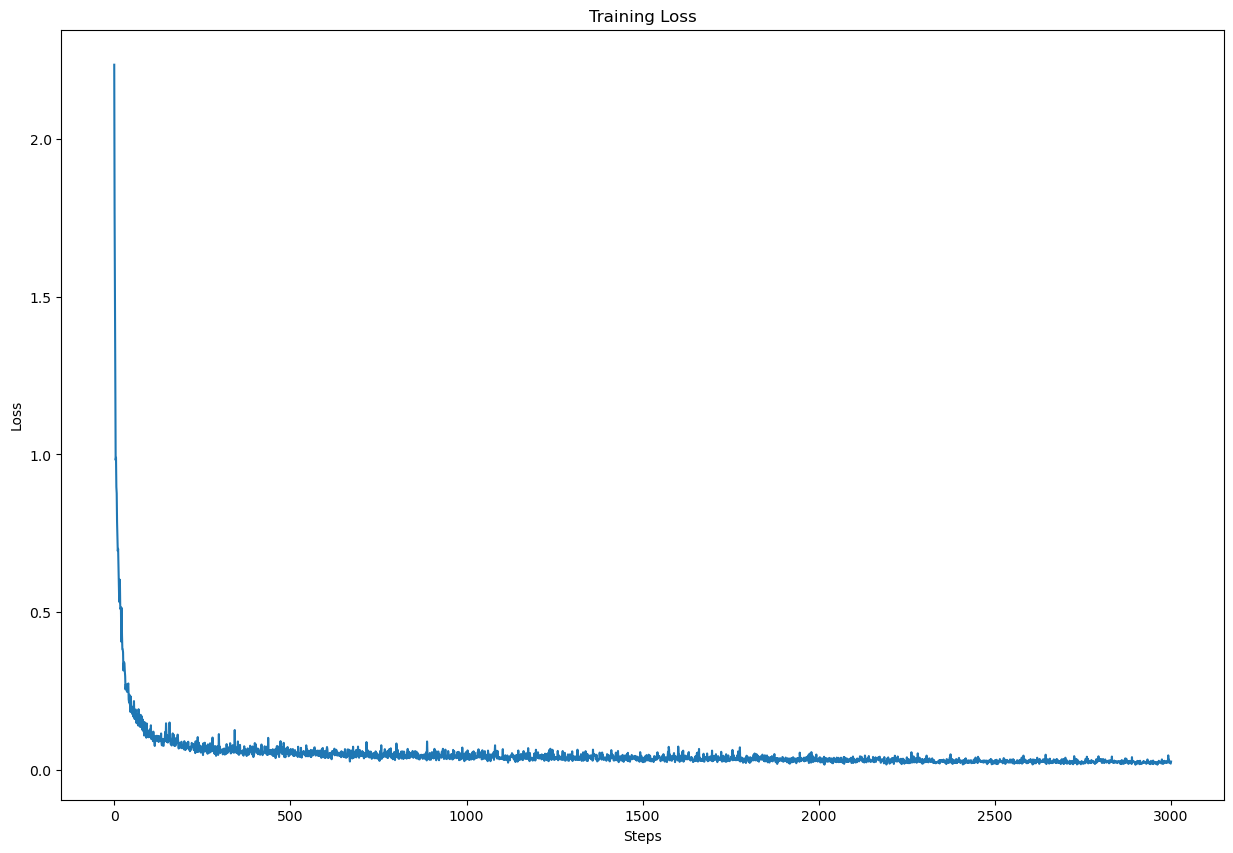

c:\ProgramData\anaconda3\envs\Seminar_project\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


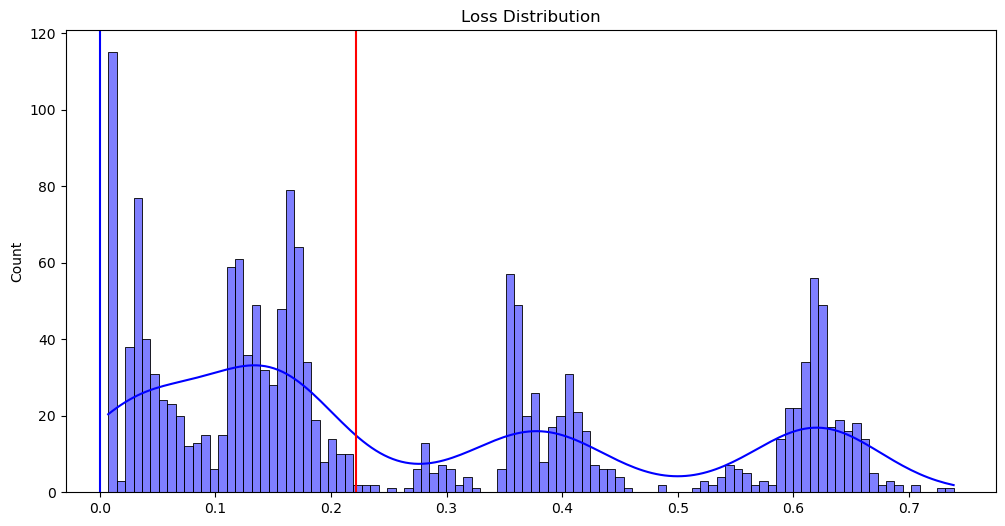

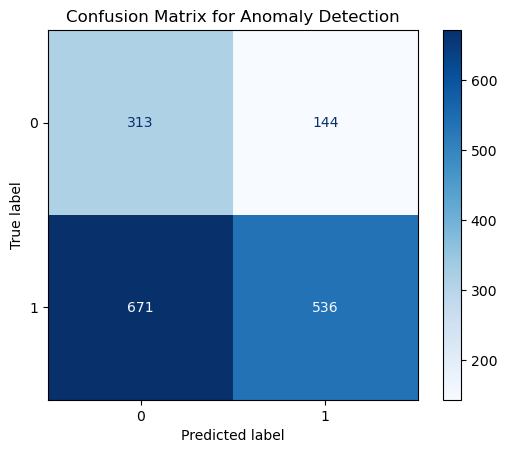

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

# Reconstruction error distribution
plt.figure(figsize=(12, 6))
plt.title('Reconstruction Error Distribution')
sns.histplot(recon_errors, bins=100, kde=True, color='blue')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Reconstructed images
z = torch.zeros(imgs.size(0), latent_size, 1, 1, device=device)
with torch.no_grad():
    gen_imgs = gen_model(z)

plt.figure(figsize=(12, 6))
plt.title('Reconstructed Images')
plt.imshow(np.transpose(torchvision.utils.make_grid(gen_imgs.cpu().detach(), padding=2, normalize=True), (1, 2, 0)))
plt.axis('off')
plt.show()

# Training loss
plt.figure(figsize=(15, 10))
plt.title('Training Loss')
plt.plot(train_losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

# Loss distribution
plt.figure(figsize=(12, 6))
plt.title('Loss Distribution')
sns.histplot(recon_errors, bins=100, kde=True, color='blue')
plt.axvline(initial_threshold, color='r')
plt.axvline(0.0, color='b')
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(true_labels_list, pred_labels_list)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Anomaly Detection')
plt.show()